In [2]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from io import StringIO
import sklearn as skn
from scipy import stats
import pandas_datareader.data as pdr
import riskfolio as rp
from scipy.stats import multivariate_normal


In [3]:
def loadStooqData(ticker: str,start, frequency='d'):
    url = f'https://stooq.pl/q/d/l/?s={ticker}&i={frequency}'
    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text))
    data.set_index('Data', inplace=True)
    data = data[start:]
    return data['Zamkniecie']

def loadYahooData(ticker, start, frequency = '1d'):
    ticker  = yf.Ticker(ticker)
    hist = ticker.history(start=start,interval=frequency)
    price = hist['Close']
    return price

def sharp(returns):
    return returns.mean()/returns.std()

def assets_performance(returns: pd.DataFrame):
    return returns.agg(['mean', 'std', 'median', 'skew', 'kurtosis', sharp])

def beta(X, Y):

    X_cov = X.cov()

    XY = np.append(X,np.expand_dims(Y,axis=1),axis=0)
    XY_cov = np.cov(XY)

    #XY_sub = XY_cov.iloc[-1,0:2]

    #inv = np.linalg.inv(X_cov)
    #B = inv @ XY_sub
    return  XY_cov

In [4]:
yahoo_tickers = ['ACWI', 'CORP.L', 'IHYU.L']

stooq_tickers = ['XAUPLN', '^TBSP', 'MWIG40', 'USDPLN', 'EURPLN', 'PLOPLN3M', 'cpiypl.m']

#na przyszłość EAFA,EEM,ACWI



In [5]:
base_prices = pd.DataFrame({})
start = '2008-01-01'

for ticker in stooq_tickers:
    base_prices[ticker] = loadStooqData(ticker,start)

for ticker in yahoo_tickers:
    base_prices[ticker] = loadYahooData(ticker,start)

base_prices.index = pd.DatetimeIndex(base_prices.index)


In [6]:
#get monthly data
monthly_base_prices = base_prices.resample('m').last()

In [7]:
monthly_base_returns = np.log(monthly_base_prices/monthly_base_prices.shift(1))
assets_performance(monthly_base_returns)

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,XAUPLN,^TBSP,MWIG40,USDPLN,EURPLN,PLOPLN3M,cpiypl.m,ACWI,CORP.L,IHYU.L
mean,0.006698,0.003260,0.002343,0.002808,0.001146,0.000912,NaN,0.005154,-0.001231,-0.000532
std,0.053787,0.012793,0.060653,0.040153,0.021731,0.149127,NaN,0.050630,0.019748,0.023259
median,0.003995,0.003729,0.006322,0.000648,-0.000957,0.000000,0.0,0.011982,0.001964,0.001948
skew,0.599417,0.204609,-0.967990,0.789085,0.667373,2.912011,NaN,-0.753528,-0.693196,-0.214753
kurtosis,1.900775,5.224806,5.526832,1.999381,2.585207,38.493633,NaN,1.502052,2.555984,2.412539
sharp,0.124531,0.254807,0.038623,0.069939,0.052716,0.006112,NaN,0.101802,-0.062321,-0.022877


In [8]:
monthly_base_returns.corr()

,XAUPLN,^TBSP,MWIG40,USDPLN,EURPLN,PLOPLN3M,cpiypl.m,ACWI,CORP.L,IHYU.L
XAUPLN,1.000000,0.085883,-0.263646,0.487478,0.526335,-0.020730,0.110625,-0.384317,0.032887,0.007977
^TBSP,0.085883,1.000000,0.156733,-0.201548,-0.102213,-0.384000,0.008257,0.231089,0.544589,0.262463
MWIG40,-0.263646,0.156733,1.000000,-0.565325,-0.538177,-0.038507,0.019465,0.773345,0.543832,0.548638
USDPLN,0.487478,-0.201548,-0.565325,1.000000,0.751510,0.018983,-0.070988,-0.715077,-0.595300,-0.409519
EURPLN,0.526335,-0.102213,-0.538177,0.751510,1.000000,-0.028341,-0.077731,-0.568022,-0.421295,-0.399171
PLOPLN3M,-0.020730,-0.384000,-0.038507,0.018983,-0.028341,1.000000,0.109378,-0.021957,-0.117679,-0.090137
cpiypl.m,0.110625,0.008257,0.019465,-0.070988,-0.077731,0.109378,1.000000,0.065932,0.071317,0.091247
ACWI,-0.384317,0.231089,0.773345,-0.715077,-0.568022,-0.021957,0.065932,1.000000,0.690002,0.709671
CORP.L,0.032887,0.544589,0.543832,-0.595300,-0.421295,-0.117679,0.071317,0.690002,1.000000,0.597967
IHYU.L,0.007977,0.262463,0.548638,-0.409519,-0.399171,-0.090137,0.091247,0.709671,0.597967,1.000000


In [9]:
#calculate pln returns
pln_prices = monthly_base_prices
pln_prices['ACWI'] = monthly_base_prices['ACWI'] * monthly_base_prices['USDPLN']
pln_prices['CORP.L'] = monthly_base_prices['CORP.L'] * monthly_base_prices['USDPLN']
pln_returns = np.log(pln_prices/pln_prices.shift(1))
pln_returns['PLOPLN3M'] = pln_prices['PLOPLN3M'] / 100 / 12
pln_returns['cpiypl.m'] = pln_prices['cpiypl.m'] / 100
pln_returns['edo'] = (pln_returns['cpiypl.m'].rolling(12).mean() + 0.015)/ 12
assets_performance(pln_returns)

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,XAUPLN,^TBSP,MWIG40,USDPLN,EURPLN,PLOPLN3M,cpiypl.m,ACWI,CORP.L,IHYU.L,edo
mean,0.006698,0.003260,0.002343,0.002808,0.001146,0.002665,0.035389,0.008468,0.000695,-0.000532,0.004063
std,0.053787,0.012793,0.060653,0.040153,0.021731,0.001677,0.042171,0.035603,0.023714,0.023259,0.003258
median,0.003995,0.003729,0.006322,0.000648,-0.000957,0.002242,0.028000,0.008942,0.001258,0.001948,0.003882
skew,0.599417,0.204609,-0.967990,0.789085,0.667373,0.476524,1.933574,-0.267492,0.233607,-0.214753,1.842493
kurtosis,1.900775,5.224806,5.526832,1.999381,2.585207,-0.820155,3.692461,0.664874,-0.369410,2.412539,3.574766
sharp,0.124531,0.254807,0.038623,0.069939,0.052716,1.589277,0.839176,0.237847,0.029326,-0.022877,1.247117


In [10]:
pln_returns.corr()

,XAUPLN,^TBSP,MWIG40,USDPLN,EURPLN,PLOPLN3M,cpiypl.m,ACWI,CORP.L,IHYU.L,edo
XAUPLN,1.000000,0.085883,-0.263646,0.487478,0.526335,0.022641,0.002786,-0.001386,0.487457,0.007977,-0.025621
^TBSP,0.085883,1.000000,0.156733,-0.201548,-0.102213,0.132692,-0.025869,0.092047,0.162412,0.262463,0.076447
MWIG40,-0.263646,0.156733,1.000000,-0.565325,-0.538177,-0.158178,-0.043422,0.457386,-0.116982,0.548638,0.044864
USDPLN,0.487478,-0.201548,-0.565325,1.000000,0.751510,0.039753,-0.039261,0.108495,0.743160,-0.409519,-0.072730
EURPLN,0.526335,-0.102213,-0.538177,0.751510,1.000000,0.015959,-0.044545,0.037810,0.554470,-0.399171,-0.061043
PLOPLN3M,0.022641,0.132692,-0.158178,0.039753,0.015959,1.000000,0.643161,-0.151057,-0.146485,-0.013884,0.727871
cpiypl.m,0.002786,-0.025869,-0.043422,-0.039261,-0.044545,0.643161,1.000000,-0.111516,-0.180066,-0.058585,0.932642
ACWI,-0.001386,0.092047,0.457386,0.108495,0.037810,-0.151057,-0.111516,1.000000,0.484174,0.490621,-0.068996
CORP.L,0.487457,0.162412,-0.116982,0.743160,0.554470,-0.146485,-0.180066,0.484174,1.000000,0.060078,-0.201137
IHYU.L,0.007977,0.262463,0.548638,-0.409519,-0.399171,-0.013884,-0.058585,0.490621,0.060078,1.000000,-0.001092


In [11]:
pln_returns.mean() * 12

XAUPLN      0.080377
^TBSP       0.039118
MWIG40      0.028111
USDPLN      0.033699
EURPLN      0.013747
PLOPLN3M    0.031977
cpiypl.m    0.424670
ACWI        0.101617
CORP.L      0.008345
IHYU.L     -0.006385
edo         0.048757
dtype: float64

In [12]:
expected_returns = pd.Series({
'ACWI': 0.085/12,
'^TBSP': 0.049/12,
'XAUPLN': 0.065/12,
'MWIG40': 0.08/12,
'IHYU.L': 0.038/12,
'PLOPLN3M': 0.03/12,
'edo': 0.04/12
})


* load data
* describe data in local currency
* transform data do pln
* describe data in pln

In [13]:
assets = ['ACWI', '^TBSP', 'XAUPLN', 'MWIG40', 'PLOPLN3M', 'edo']
#
returns = pln_returns[assets]
cov_matrix = pln_returns[assets].cov()
mu = expected_returns[assets]

portfolio = rp.Portfolio(returns)

portfolio.mu = mu
portfolio.cov = cov_matrix

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = portfolio.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo
weights,0.009488,0.00274,0.002444,0.004105,0.981224,4.254964e-10


In [14]:
w = portfolio.optimization(model=model, rm=rm, obj='MaxRet', rf=rf, l=l, hist=hist)

display(np.round(w.T,2))

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo
weights,1.0,0.0,0.0,0.0,0.0,0.0


In [15]:
def frontier_performance(frontier,mu,cov,rf = 0.0):
    result = frontier.copy()
    result['Returns'] = np.round(frontier.to_numpy() @ mu *12,4)
    result['Std. deviations'] = frontier.apply(lambda x: np.round(np.sqrt(x.to_numpy().T @ cov @ x.to_numpy())* np.sqrt(12),4),axis=1)
    result['SR'] = np.round((result['Returns']-rf) / result['Std. deviations'],2)
    return result


In [16]:
def shrinkedCovariance(returns: pd.DataFrame, w: int):
    std = np.diag(returns.std())
    corr = returns.corr('pearson')
    shrinked_corr = (1-w)*corr + np.ones_like(corr)*w
    result = std @ shrinked_corr @ std
    return result

shrin_param = 0.75

In [17]:
points = 10
frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_10 = np.round(frontier.T,2)

In [18]:
frontier_performance(frontier_10, expected_returns[assets],cov_matrix,0.0298)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.01,0.00,0.00,0.00,0.99,0.00,0.0306,0.0057,0.14
1,0.11,0.16,0.03,0.01,0.00,0.70,0.0479,0.0194,0.93
2,0.20,0.27,0.05,0.02,0.00,0.47,0.0539,0.0322,0.75
3,0.28,0.37,0.08,0.02,0.00,0.25,0.0587,0.0444,0.65
4,0.36,0.47,0.10,0.03,0.00,0.03,0.0637,0.0571,0.59
5,0.47,0.35,0.13,0.05,0.00,0.00,0.0696,0.0707,0.56
6,0.58,0.20,0.15,0.06,0.00,0.00,0.0737,0.0835,0.53
7,0.68,0.06,0.18,0.08,0.00,0.00,0.0788,0.0975,0.50
8,0.85,0.00,0.11,0.04,0.00,0.00,0.0826,0.1104,0.48
9,1.00,0.00,0.00,0.00,0.00,0.00,0.0850,0.1233,0.45


In [19]:
mu = expected_returns[assets]
shrinked_cov = shrinkedCovariance(pln_returns[assets],shrin_param)

portfolio.mu = mu
portfolio.cov = shrinked_cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_10_sh = np.round(frontier.T,2)

In [20]:
frontier_performance(frontier_10_sh,mu,shrinked_cov,0.0298)


,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.0,0.0,0.0,1.0,0.00,0.0300,0.0058,0.03
1,0.08,0.0,0.0,0.0,0.0,0.92,0.0436,0.0188,0.73
2,0.20,0.0,0.0,0.0,0.0,0.80,0.0490,0.0319,0.60
3,0.32,0.0,0.0,0.0,0.0,0.68,0.0544,0.0454,0.54
4,0.43,0.0,0.0,0.0,0.0,0.57,0.0594,0.0579,0.51
5,0.55,0.0,0.0,0.0,0.0,0.45,0.0648,0.0716,0.49
6,0.66,0.0,0.0,0.0,0.0,0.34,0.0697,0.0843,0.47
7,0.77,0.0,0.0,0.0,0.0,0.23,0.0746,0.0969,0.46
8,0.89,0.0,0.0,0.0,0.0,0.11,0.0801,0.1107,0.45
9,1.00,0.0,0.0,0.0,0.0,0.00,0.0850,0.1233,0.45


In [21]:
mu = expected_returns[assets]
cov = pln_returns[0:60][assets].cov()

portfolio.mu = mu
portfolio.cov = cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_1_5 = np.round(frontier.T,2)

In [22]:
frontier_performance(frontier_1_5,mu,cov)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.00,0.00,0.00,0.25,0.75,0.0375,0.0016,23.44
1,0.09,0.24,0.01,0.00,0.00,0.65,0.0461,0.0157,2.94
2,0.17,0.47,0.03,0.00,0.00,0.33,0.0526,0.0304,1.73
3,0.26,0.70,0.04,0.00,0.00,0.01,0.0594,0.0457,1.30
4,0.40,0.54,0.06,0.00,0.00,0.00,0.0644,0.0602,1.07
5,0.51,0.40,0.08,0.01,0.00,0.00,0.0690,0.0744,0.93
6,0.62,0.26,0.10,0.02,0.00,0.00,0.0735,0.0893,0.82
7,0.72,0.13,0.12,0.04,0.00,0.00,0.0786,0.1045,0.75
8,0.83,0.00,0.13,0.04,0.00,0.00,0.0822,0.1184,0.69
9,1.00,0.00,0.00,0.00,0.00,0.00,0.0850,0.1329,0.64


In [23]:
mu = expected_returns[assets]
shrinked_cov = shrinkedCovariance(pln_returns[0:60][assets],shrin_param)

portfolio.mu = mu
portfolio.cov = shrinked_cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_1_5_sh = np.round(frontier.T,2)

In [24]:
frontier_performance(frontier_1_5_sh,mu,shrinked_cov)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.00,0.0,0.0,0.0,1.00,0.0400,0.0016,25.00
1,0.11,0.00,0.0,0.0,0.0,0.88,0.0446,0.0157,2.84
2,0.22,0.03,0.0,0.0,0.0,0.75,0.0502,0.0310,1.62
3,0.32,0.06,0.0,0.0,0.0,0.62,0.0549,0.0450,1.22
4,0.43,0.08,0.0,0.0,0.0,0.49,0.0601,0.0600,1.00
5,0.54,0.11,0.0,0.0,0.0,0.36,0.0657,0.0752,0.87
6,0.64,0.13,0.0,0.0,0.0,0.23,0.0700,0.0889,0.79
7,0.75,0.16,0.0,0.0,0.0,0.10,0.0756,0.1042,0.73
8,0.86,0.14,0.0,0.0,0.0,0.00,0.0800,0.1181,0.68
9,1.00,0.00,0.0,0.0,0.0,0.00,0.0850,0.1329,0.64


In [25]:
mu = expected_returns[assets]
cov = pln_returns[60:120][assets].cov()

portfolio.mu = mu
portfolio.cov = cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_5_10 = np.round(frontier.T,2)

In [26]:
frontier_performance(frontier_5_10,mu,cov)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.00,0.00,0.00,1.0,0.00,0.0300,0.0017,17.65
1,0.08,0.17,0.01,0.04,0.0,0.70,0.0470,0.0122,3.85
2,0.15,0.32,0.02,0.08,0.0,0.43,0.0533,0.0228,2.34
3,0.23,0.47,0.03,0.11,0.0,0.16,0.0597,0.0336,1.78
4,0.32,0.48,0.05,0.15,0.0,0.00,0.0660,0.0443,1.49
5,0.42,0.32,0.06,0.20,0.0,0.00,0.0713,0.0551,1.29
6,0.52,0.18,0.07,0.23,0.0,0.00,0.0760,0.0655,1.16
7,0.61,0.04,0.08,0.27,0.0,0.00,0.0806,0.0763,1.06
8,0.81,0.00,0.00,0.19,0.0,0.00,0.0841,0.0872,0.96
9,1.00,0.00,0.00,0.00,0.0,0.00,0.0850,0.0979,0.87


In [27]:
shrinked_cov = shrinkedCovariance(pln_returns[60:120][assets],shrin_param)

portfolio.mu = mu
portfolio.cov = shrinked_cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_5_10_sh = np.round(frontier.T,2)

In [28]:
frontier_performance(frontier_5_10_sh,mu,shrinked_cov)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.0,0.0,0.0,1.0,0.00,0.0300,0.0017,17.65
1,0.10,0.0,0.0,0.0,0.0,0.90,0.0445,0.0121,3.68
2,0.22,0.0,0.0,0.0,0.0,0.78,0.0499,0.0235,2.12
3,0.33,0.0,0.0,0.0,0.0,0.67,0.0549,0.0340,1.61
4,0.44,0.0,0.0,0.0,0.0,0.56,0.0598,0.0445,1.34
5,0.55,0.0,0.0,0.0,0.0,0.45,0.0648,0.0550,1.18
6,0.66,0.0,0.0,0.0,0.0,0.34,0.0697,0.0655,1.06
7,0.78,0.0,0.0,0.0,0.0,0.22,0.0751,0.0769,0.98
8,0.89,0.0,0.0,0.0,0.0,0.11,0.0801,0.0874,0.92
9,1.00,0.0,0.0,0.0,0.0,0.00,0.0850,0.0979,0.87


In [29]:
start = '01.12.2006'
tbsp = loadStooqData('^TBSP',start,'m')
wibor3 = loadStooqData('PLOPLN3M',start,'m')
cpi = loadStooqData('cpimpl.m',start,'m')

In [30]:
tbsp = np.log(tbsp/tbsp.shift(1))
wibor3 = wibor3/100/12
cpi = cpi/100

In [31]:
tbsp.loc['2007-01-01':].mean()*12
#'2019-12-31'

0.03854564435334258

In [32]:
wibor3.loc['2007-01-01':].mean() * 12

0.032939

In [33]:
cpi.loc['2007-01-01':].mean() *12

0.036000000000000025

In [34]:
print(tbsp.loc['2007-01-01':'2019-12-31'].mean()*12)
print(wibor3.loc['2007-01-01':'2019-12-31'].mean() * 12)
print(cpi.loc['2007-01-01':'2019-19-31'].mean() *12)

0.049864919419809195
0.03302307692307694
0.02115384615384617


In [35]:
tbsp_cum = (1+tbsp.loc['2007-01-01':'2023-06-31']).cumprod()[-1]
cpi_cum = (1.00125+cpi.loc['2007-01-01':'2023-06-31']).cumprod()[-1]
wibor_cum = (1+wibor3.loc['2007-01-01':'2023-06-31']/12).cumprod()[-1]

In [36]:
print(tbsp_cum)
print(cpi_cum)
print(wibor_cum)

1.8398585720934704
2.3014767048682354
1.045825968849171


In [37]:
assets = ['ACWI', '^TBSP', 'XAUPLN', 'MWIG40', 'PLOPLN3M', 'edo']
means = expected_returns[assets]
cov = pln_returns[assets].cov()
number_of_scenarios = 1001
T = 60
sim_returns = []

for s in range (number_of_scenarios):
    sim_returns.append(multivariate_normal.rvs(means,cov, T))

sim_returns = np.array(sim_returns)

In [38]:
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'
points = 10
weights = np.zeros((number_of_scenarios,len(assets),points))

for p in range(number_of_scenarios):
    portfolio = rp.Portfolio(pd.DataFrame(sim_returns[p], columns=assets))
    portfolio.assets_stats(method_mu='hist', method_cov='hist')
    w = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
    weights[p,:] = w.to_numpy()


In [39]:
w_means = np.round(weights.mean(0),2)
w_means_df = pd.DataFrame(w_means.T, columns=assets)

In [40]:
w_means_df

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo
0,0.01,0.00,0.00,0.00,0.98,0.00
1,0.07,0.15,0.05,0.03,0.04,0.65
2,0.13,0.26,0.09,0.07,0.02,0.44
3,0.18,0.26,0.14,0.11,0.02,0.29
4,0.24,0.21,0.19,0.15,0.01,0.20
5,0.27,0.16,0.23,0.19,0.01,0.14
6,0.27,0.12,0.27,0.24,0.01,0.09
7,0.26,0.09,0.30,0.28,0.00,0.06
8,0.25,0.07,0.31,0.32,0.00,0.04
9,0.25,0.05,0.32,0.35,0.00,0.02


In [41]:
sim_returns.mean(1) * 12

array([[ 0.13392487,  0.05490706,  0.05153696,  0.12172923,  0.02877948,
         0.03914109],
       [ 0.06910633,  0.03539178,  0.14694245, -0.00619131,  0.02749833,
         0.04031185],
       [ 0.05831483,  0.04661399, -0.00590502,  0.12183034,  0.028296  ,
         0.04201105],
       ...,
       [ 0.07544994,  0.08498658,  0.1382093 , -0.00586614,  0.03565863,
         0.04687201],
       [ 0.04244521,  0.03664578,  0.07597878, -0.17258061,  0.02716113,
         0.03399083],
       [ 0.15006671,  0.03809201,  0.12022787,  0.17478419,  0.03104842,
         0.04148735]])

In [75]:
def turbulance(returns, mean, cov):
    diff = returns - mean
    result = diff.T @ np.linalg.inv(cov) @ diff 
    return result/len(mean)

assets = ['ACWI', '^TBSP', 'XAUPLN', 'MWIG40','PLOPLN3M', 'edo']
returns = pln_returns['2008-01-01':'2022-12-31'][assets]
mean = returns.mean()
cov_matrix = returns.cov()

returns['Turbulance'] = returns.apply(turbulance, axis=1, args=(mean, cov_matrix))
returns['Reccesion'] = returns['Turbulance'] > 1.5

<AxesSubplot:xlabel='Data', ylabel='Turbulance'>

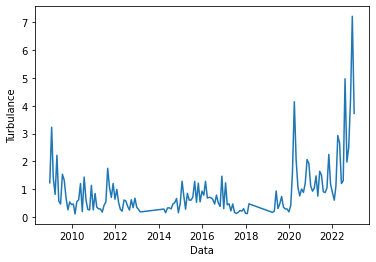

In [76]:
sns.lineplot(data=returns['Turbulance'])

In [77]:
turbulance_returns = returns[returns['Reccesion'] == True]
assets_performance(turbulance_returns)

C:\Users\matsz\AppData\Local\Temp\ipykernel_13764\1005095042.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  return returns.mean()/returns.std()


,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Turbulance,Reccesion
mean,0.007353,0.000737,0.016585,0.004227,0.003215,0.006685,2.806892,1.0
std,0.056653,0.027582,0.075085,0.115030,0.002412,0.003431,1.438219,0.0
median,0.010763,0.004823,0.017117,0.015477,0.003758,0.004632,2.236805,1.0
skew,-0.014894,0.445735,1.064661,-0.123710,-0.117059,0.865435,1.776099,0.0
kurtosis,-0.973002,0.711604,2.363752,-0.820479,-1.737046,-0.965244,3.515573,0.0
sharp,0.129787,0.026722,0.220883,0.036748,1.332917,1.948607,1.951644,inf


In [78]:
turbulance_returns.corr()

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Turbulance,Reccesion
ACWI,1.000000,0.165528,-0.160279,0.661485,-0.144709,-0.151872,0.060003,NaN
^TBSP,0.165528,1.000000,0.073755,0.059732,0.023137,0.018171,0.462607,NaN
XAUPLN,-0.160279,0.073755,1.000000,-0.538422,0.044572,-0.145301,0.080185,NaN
MWIG40,0.661485,0.059732,-0.538422,1.000000,-0.061983,0.016015,-0.027655,NaN
PLOPLN3M,-0.144709,0.023137,0.044572,-0.061983,1.000000,0.848463,0.539124,NaN
edo,-0.151872,0.018171,-0.145301,0.016015,0.848463,1.000000,0.647931,NaN
Turbulance,0.060003,0.462607,0.080185,-0.027655,0.539124,0.647931,1.000000,NaN
Reccesion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
turbulente_mu = turbulance_returns[assets].mean()
turbulente_cov = turbulance_returns[assets].cov()

porfolio = rp.Portfolio(turbulance_returns[assets].dropna())
portfolio.mu = turbulente_mu
portfolio.cov = turbulente_cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_turbulent = np.round(frontier.T,2)
frontier_performance(frontier_turbulent, mu, cov, 0.004*12)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.01,0.0,0.00,0.00,0.99,0.00,0.0310,0.0053,-3.21
1,0.00,0.0,0.16,0.04,0.00,0.79,0.0463,0.0294,-0.06
2,0.00,0.0,0.29,0.08,0.00,0.63,0.0512,0.0527,0.06
3,0.00,0.0,0.42,0.11,0.00,0.47,0.0558,0.0762,0.10
4,0.00,0.0,0.54,0.14,0.00,0.31,0.0597,0.0980,0.12
5,0.00,0.0,0.67,0.18,0.00,0.15,0.0645,0.1217,0.14
6,0.00,0.0,0.79,0.21,0.00,0.00,0.0687,0.1435,0.14
7,0.00,0.0,0.87,0.13,0.00,0.00,0.0743,0.1587,0.17
8,0.00,0.0,0.94,0.06,0.00,0.00,0.0792,0.1739,0.18
9,0.00,0.0,1.00,0.00,0.00,0.00,0.0834,0.1881,0.19


In [85]:
non_turbulance_returns = returns[returns['Reccesion'] == False]
assets_performance(non_turbulance_returns)

C:\Users\matsz\AppData\Local\Temp\ipykernel_13764\1005095042.py:16: RuntimeWarning: invalid value encountered in double_scalars
  return returns.mean()/returns.std()


,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Turbulance,Reccesion
mean,0.008656,0.003200,0.005879,0.000781,0.002443,0.003062,0.628910,0.0
std,0.032753,0.009416,0.051470,0.051227,0.001433,0.001705,0.369749,0.0
median,0.009164,0.003491,0.000401,0.005461,0.002137,0.003458,0.548590,0.0
skew,-0.397294,-0.057245,0.357363,-1.778160,0.535762,0.192436,0.592898,0.0
kurtosis,0.926280,1.722408,1.145294,10.290743,-0.538761,0.170469,-0.717858,0.0
sharp,0.264295,0.339845,0.114225,0.015244,1.705179,1.795560,1.700911,NaN


In [86]:
non_turbulance_returns.corr()

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Turbulance,Reccesion
ACWI,1.000000,0.016043,0.036198,0.365537,-0.172018,-0.062424,0.014760,NaN
^TBSP,0.016043,1.000000,0.092410,0.193968,0.160374,-0.042221,-0.219029,NaN
XAUPLN,0.036198,0.092410,1.000000,-0.169169,0.025328,0.036885,0.170878,NaN
MWIG40,0.365537,0.193968,-0.169169,1.000000,-0.293398,-0.108534,-0.049824,NaN
PLOPLN3M,-0.172018,0.160374,0.025328,-0.293398,1.000000,0.581642,-0.069924,NaN
edo,-0.062424,-0.042221,0.036885,-0.108534,0.581642,1.000000,0.154609,NaN
Turbulance,0.014760,-0.219029,0.170878,-0.049824,-0.069924,0.154609,1.000000,NaN
Reccesion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
non_turbulance_mu = non_turbulance_returns[assets].mean()
non_turbulance_cov = non_turbulance_returns[assets].cov()

porfolio = rp.Portfolio(non_turbulance_returns[assets].dropna())
portfolio.mu = non_turbulance_mu
portfolio.cov = non_turbulance_cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_non_turbulent = np.round(frontier.T,2)
frontier_performance(frontier_non_turbulent, mu, cov, 0.002498*12)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.00,0.00,0.01,0.72,0.27,0.0330,0.0053,0.57
1,0.13,0.05,0.02,0.00,0.00,0.79,0.0492,0.0173,1.11
2,0.24,0.06,0.04,0.00,0.00,0.66,0.0571,0.0310,0.87
3,0.34,0.06,0.06,0.00,0.00,0.53,0.0637,0.0438,0.77
4,0.44,0.07,0.08,0.00,0.00,0.41,0.0710,0.0568,0.72
5,0.55,0.08,0.10,0.00,0.00,0.28,0.0790,0.0710,0.69
6,0.65,0.09,0.12,0.00,0.00,0.15,0.0859,0.0841,0.66
7,0.75,0.09,0.14,0.00,0.00,0.02,0.0924,0.0971,0.64
8,0.86,0.00,0.14,0.00,0.00,0.00,0.0997,0.1099,0.63
9,1.00,0.00,0.00,0.00,0.00,0.00,0.1023,0.1242,0.58


In [88]:
mu = 0.1*turbulente_mu + 0.9 * non_turbulance_mu
cov = 0.1*turbulente_cov + 0.9 * non_turbulance_cov

porfolio = rp.Portfolio(returns[assets].dropna())
portfolio.mu = mu
portfolio.cov = cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_combined = np.round(frontier.T,2)
frontier_performance(frontier_combined, mu, cov, 0.002498*12)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.0,0.00,0.0,0.8,0.19,0.0320,0.0052,0.39
1,0.13,0.0,0.04,0.0,0.0,0.83,0.0507,0.0182,1.14
2,0.23,0.0,0.07,0.0,0.0,0.70,0.0581,0.0314,0.90
3,0.33,0.0,0.10,0.0,0.0,0.57,0.0655,0.0449,0.79
4,0.43,0.0,0.13,0.0,0.0,0.44,0.0729,0.0584,0.74
5,0.52,0.0,0.16,0.0,0.0,0.32,0.0797,0.0709,0.70
6,0.62,0.0,0.19,0.0,0.0,0.19,0.0871,0.0846,0.68
7,0.72,0.0,0.22,0.0,0.0,0.07,0.0949,0.0983,0.66
8,0.87,0.0,0.13,0.0,0.0,0.00,0.0999,0.1107,0.63
9,1.00,0.0,0.00,0.0,0.0,0.00,0.1023,0.1242,0.58
